# Deep Q-Learning to solve CarRacing-v0

We will use a simple feedforward neural network (FFNN) to solve the CarRacing-v0 environment. This is based on [Luc Prieur's solution](https://gist.github.com/lmclupr/b35c89b2f8f81b443166e88b787b03ab#file-race-car-cv2-nn-network-td0-15-possible-actions-ipynb). However, we will be adding and playing more with it, as it did not solve the environment: it obtained a mean reward of 342.69+-17.64, whereas Gym considers the environment as being solved when the agent obtains an average reward of at least 900 (over 100 consecutive episodes.

In [3]:
import os
# import sys
# from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
# from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation#, Dropout, Embedding, Flatten, Convolution2D, MaxPooling2D, Merge
from keras.optimizers import Adamax #, SGD, RMSprop, Adam, 
# from keras.utils import np_utils
import cv2

import gym
from gym import wrappers

In [4]:
sns.set_style("ticks")
sns.despine()

def plot_running_avg(total_rewards):
    N = len(total_rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = total_rewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()

In [5]:
env = gym.make("CarRacing-v0")

[2017-10-20 18:46:24,663] Making new env: CarRacing-v0


In [6]:
env = wrappers.Monitor(env, "train_1", force=True, mode='training')
#env = wrappers.Monitor(env, "larger_image", resume=True, mode='training')
#env = wrappers.Monitor(env, "larger_image", resume=True, mode='evaluation')

[2017-10-20 18:46:27,532] Creating monitor directory train_1


In [7]:
def transform(s):
    # We will crop the digits in the lower right corner, as they yield little 
    # information to our agent, as well as grayscale the frames.
    bottom_black_bar = s[84:, 12:]
    img = cv2.cvtColor(bottom_black_bar, cv2.COLOR_RGB2GRAY)
    bottom_black_bar_bw = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1]
    bottom_black_bar_b2 = cv2.resize(bottom_black_bar_bw, (84, 12), interpolation=cv2.INTER_NEAREST)
    
    # We will crop the sides of the screen, so we have an 84x84 frame, and grayscale them:
    upper_field = s[:84, 6:90]
    img = cv2.cvtColor(upper_field, cv2.COLOR_RGB2GRAY)
    upper_field_bw = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)[1]
    upper_field_bw = cv2.resize(upper_field_bw, (10, 10), interpolation=cv2.INTER_NEAREST)
    upper_field_bw = upper_field_bw.astype('float')/255
    
    # The car occupies a very small space, we do the same preprocessing:
    car_field = s[66:78, 43:53]
    img = cv2.cvtColor(car_field, cv2.COLOR_RGB2GRAY)
    car_field_bw = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)[1]
    car_field_t = [car_field_bw[:, 3].mean()/255, 
                   car_field_bw[:, 4].mean()/255,
                   car_field_bw[:, 5].mean()/255, 
                   car_field_bw[:, 6].mean()/255]
    
    return bottom_black_bar_bw, upper_field_bw, car_field_t

In [8]:
# This function uses the bottom black bar of the screen and extracts the
# steering setting, speed, and gyroscope data.

def compute_steering_speed_gyro_abs(a):
    right_steering = a[6, 36:46].mean()/255
    left_steering = a[6, 26:36].mean()/255
    steering = (right_steering - left_steering + 1.0)/2
    
    left_gyro = a[6, 46:60].mean()/255
    right_gyro = a[6, 60:76].mean()/255
    gyro = (right_gyro - left_gyro + 1.0)/2
    
    speed = a[:, 0][:-2].mean()/255
    abs1 = a[:, 6][:-2].mean()/255
    abs2 = a[:, 8][:-2].mean()/255
    abs3 = a[:, 10][:-2].mean()/255
    abs4 = a[:, 12][:-2].mean()/255
    
    return [steering, speed, gyro, abs1, abs2, abs3, abs4]

In [9]:
vector_size = 10*10 + 7 + 4

In [10]:
def create_nn():
    if os.path.exists('race-car_larger.h5'):
        return load_model('race-car_larger.h5')
    
    model = Sequential()
    model.add(Dense(512, init='lecun_uniform', input_shape=(vector_size,)))  # 7x7+3 or 14x14+3
    model.add(Activation('relu'))
    
    model.add(Dense(11, init='lecun_uniform'))
    model.add(Activation('linear'))  # linear output so we can have a range of real-valued opts.
    
    model.compile(loss='mse', optimizer=Adamax())  # lr=0.001
    model.summary()
    
    return model

In [11]:
class Model:
    def __init__(self, env):
        self.env = env
        self.model = create_nn()  # One FFNN for all actions
        
    def predict(self, s):
        return self.model.predict(s.reshape(-1, vector_size), verbose=0)[0]
    
    def update(self, s, G):
        self.model.fit(s.reshape(-1, vector_size), 
                       np.array(G).reshape(-1, 11), 
                       nb_epoch=1, 
                       verbose=0)
        
    def sample_action(self, s, eps):
        qval = self.predict(s)
        if np.random.random() < eps:
            return random.randint(0,10), qval
        else:
            return np.argmax(qval), qval

In [12]:
def convert_argmax_qval_to_env_action(output_value):
    # We reduce the action space to 
    
    gas = 0.0
    brake = 0.0
    steering = 0.0
    
    # Output value ranges from 0 to 10:
    
    if output_value <= 8:
        # Steering, brake, and gas are zero
        output_value -= 4
        steering = float(output_value)/4
    elif output_value >=9 and output_value <=9:
        output_value -= 8
        gas = float(output_value)/3  # 33% of gas
    elif output_value >= 10 and output_value <= 10:
        output_value -= 9
        brake = float(output_value)/2  # 50% of brake
    else:
        print("Error")  #Why?
        
    white = np.ones((round(gas * 100), 10))
    black = np.zeros((round(100 - gas * 100), 10))
    gas_display = np.concatenate((black, white)) * 255
    
    white = np.ones((round(brake * 100), 10))
    black = np.zeros((round(100 - brake * 100), 10))
    brake_display = np.concatenate((black, white)) * 255
    
    control_display = np.concatenate((brake_display, gas_display), axis=1)
    
    cv2.imshow('controls', control_display)
    cv2.waitKey(1)
    
    return [steering, gas, brake]

In [13]:
def play_one(env, model, eps, gamma):
    observation = env.reset()
    done = False
    full_reward_received = False
    totalreward = 0
    iters = 0
    while not done:
        a, b, c = transform(observation)
        state = np.concatenate((np.array([compute_steering_speed_gyro_abs(a)]).reshape(1,-1).flatten(),
                               b.reshape(1, -1).flatten(),c), axis=0)  # 3+7*7 size vector, scaled in range 0-1
        argmax_qval, qval = model.sample_action(state, eps)
        prev_state = state
        action = convert_argmax_qval_to_env_action(argmax_qval)
        observation, reward, done, info = env.step(action)
        
        a, b, c = transform(observation)
        state = np.concatenate((np.array([compute_steering_speed_gyro_abs(a)]).reshape(1,-1).flatten(),
                               b.reshape(1,-1).flatten(), c), axis=0)
        
        # Update the model, standard Q-Learning TD(0)
        next_qval = model.predict(state)
        G = reward + gamma*np.max(next_qval)
        y = qval[:]
        y[argmax_qval] = G
        model.update(prev_state, y)
        totalreward += reward
        iters += 1
        
        if iters > 1600:
            print("This episode is stuck.")
            break
            
    return totalreward, iters

/home/diego/miniconda3/envs/USA/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_shape=(111,), kernel_initializer="lecun_uniform")`
  
/home/diego/miniconda3/envs/USA/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, kernel_initializer="lecun_uniform")`
  if __name__ == '__main__':


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               57344     
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                5643      
_________________________________________________________________
activation_2 (Activation)    (None, 11)                0         
Total params: 62,987
Trainable params: 62,987
Non-trainable params: 0
_________________________________________________________________
Track generation: 1169..1465 -> 296-tiles track


[2017-10-20 18:46:46,494] Starting new video recorder writing to /home/diego/Desktop/train_1/openaigym.video.0.2951.video000000.mp4
/home/diego/miniconda3/envs/USA/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Episode:  0 , iters:  1000 , total reward:  -52.54237288135656 , epsilon:  0.0166574151163 , average reward (of last 100):  -52.5423728814
Track generation: 1107..1388 -> 281-tiles track


[2017-10-20 18:47:41,174] Starting new video recorder writing to /home/diego/Desktop/train_1/openaigym.video.0.2951.video000001.mp4
/home/diego/miniconda3/envs/USA/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Episode:  1 , iters:  1000 , total reward:  -25.000000000000835 , epsilon:  0.0166481789553 , average reward (of last 100):  -38.7711864407
Track generation: 1265..1590 -> 325-tiles track
Episode:  2 , iters:  214 , total reward:  -16.36172839506129 , epsilon:  0.016638958141 , average reward (of last 100):  -31.3013670921
Track generation: 1201..1506 -> 305-tiles track
Episode:  3 , iters:  309 , total reward:  -61.7210526315793 , epsilon:  0.0166297526309 , average reward (of last 100):  -38.906288477
Track generation: 1146..1436 -> 290-tiles track
Episode:  4 , iters:  305 , total reward:  -57.735640138408655 , epsilon:  0.0166205623829 , average reward (of last 100):  -42.6721588093
Track generation: 1119..1411 -> 292-tiles track
Episode:  5 , iters:  229 , total reward:  42.14845360824805 , epsilon:  0.0166113873546 , average reward (of last 100):  -28.535390073
Track generation: 1080..1354 -> 274-tiles track
Episode:  6 , iters:  310 , total reward:  -53.97692307692323 , epsilon:

[2017-10-20 18:49:16,177] Starting new video recorder writing to /home/diego/Desktop/train_1/openaigym.video.0.2951.video000008.mp4


Episode:  7 , iters:  314 , total reward:  -50.119188191881804 , epsilon:  0.01659308279 , average reward (of last 100):  -34.4135564634
Track generation: 1100..1379 -> 279-tiles track


/home/diego/miniconda3/envs/USA/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Episode:  8 , iters:  306 , total reward:  -54.9604316546765 , epsilon:  0.0165839531702 , average reward (of last 100):  -36.6965425957
Track generation: 1015..1273 -> 258-tiles track
Episode:  9 , iters:  311 , total reward:  -49.28793774319045 , epsilon:  0.0165748386033 , average reward (of last 100):  -37.9556821105
Track generation: 1203..1514 -> 311-tiles track
Episode:  10 , iters:  224 , total reward:  9.958064516129511 , epsilon:  0.0165657390481 , average reward (of last 100):  -33.5998869626
Track generation: 1122..1413 -> 291-tiles track
Episode:  11 , iters:  220 , total reward:  19.479310344828235 , epsilon:  0.0165566544633 , average reward (of last 100):  -29.1766205203
Track generation: 1108..1389 -> 281-tiles track
Episode:  12 , iters:  309 , total reward:  -55.8000000000003 , epsilon:  0.016547584808 , average reward (of last 100):  -31.224572788
Track generation: 1084..1365 -> 281-tiles track
Episode:  13 , iters:  218 , total reward:  21.157142857143413 , epsilon

[2017-10-20 18:52:12,198] Starting new video recorder writing to /home/diego/Desktop/train_1/openaigym.video.0.2951.video000027.mp4


Episode:  26 , iters:  304 , total reward:  -53.094117647058944 , epsilon:  0.0164221546361 , average reward (of last 100):  -29.8240187006
Track generation: 1021..1280 -> 259-tiles track


/home/diego/miniconda3/envs/USA/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Episode:  27 , iters:  282 , total reward:  -46.7046511627905 , epsilon:  0.0164133041075 , average reward (of last 100):  -30.4268984314
Track generation: 1159..1453 -> 294-tiles track
Episode:  28 , iters:  269 , total reward:  -55.127645051194825 , epsilon:  0.0164044678731 , average reward (of last 100):  -31.2786483148
Track generation: 1049..1309 -> 260-tiles track
Episode:  29 , iters:  290 , total reward:  -51.6799227799229 , epsilon:  0.0163956458946 , average reward (of last 100):  -31.958690797
Track generation: 1086..1361 -> 275-tiles track
Episode:  30 , iters:  1000 , total reward:  -23.3576642335773 , epsilon:  0.0163868381336 , average reward (of last 100):  -31.6812383272
Track generation: 1164..1459 -> 295-tiles track
Episode:  31 , iters:  1000 , total reward:  -28.57142857142937 , epsilon:  0.016378044552 , average reward (of last 100):  -31.5840567723
Track generation: 872..1101 -> 229-tiles track
Episode:  32 , iters:  227 , total reward:  65.99649122807094 , epsi

[2017-10-20 19:03:32,180] Starting new video recorder writing to /home/diego/Desktop/train_1/openaigym.video.0.2951.video000064.mp4


Episode:  63 , iters:  237 , total reward:  47.13170731707379 , epsilon:  0.01610391566 , average reward (of last 100):  -5.29919064823
Track generation: 1301..1631 -> 330-tiles track


/home/diego/miniconda3/envs/USA/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Episode:  64 , iters:  1000 , total reward:  -39.20972644376982 , epsilon:  0.0160955694995 , average reward (of last 100):  -5.82089119893
Track generation: 1107..1393 -> 286-tiles track
Episode:  65 , iters:  1000 , total reward:  26.315789473686543 , epsilon:  0.0160872363022 , average reward (of last 100):  -5.3339717948
Track generation: 1299..1628 -> 329-tiles track
Episode:  66 , iters:  1000 , total reward:  -32.92682926829351 , epsilon:  0.0160789160346 , average reward (of last 100):  -5.74580548844
Track generation: 1246..1561 -> 315-tiles track
Episode:  67 , iters:  1000 , total reward:  170.70063694267532 , epsilon:  0.0160706086633 , average reward (of last 100):  -3.15100486445
Track generation: 1059..1328 -> 269-tiles track
Episode:  68 , iters:  1000 , total reward:  202.23880597015022 , epsilon:  0.0160623141551 , average reward (of last 100):  -0.174340939312
Track generation: 1157..1450 -> 293-tiles track
Episode:  69 , iters:  1000 , total reward:  -31.50684931506

Episode:  107 , iters:  1000 , total reward:  335.6435643564215 , epsilon:  0.0157485197087 , average reward (of last 100):  55.8305977398
Track generation: 1406..1762 -> 356-tiles track
Episode:  108 , iters:  1000 , total reward:  145.07042253521584 , epsilon:  0.0157407137505 , average reward (of last 100):  57.7631681431
Track generation: 1089..1361 -> 272-tiles track
Episode:  109 , iters:  463 , total reward:  329.8147601475983 , epsilon:  0.0157329193882 , average reward (of last 100):  61.5728235075
Track generation: 1162..1465 -> 303-tiles track
Episode:  110 , iters:  234 , total reward:  42.26291390728545 , epsilon:  0.0157251365931 , average reward (of last 100):  62.4792675832
Track generation: 1266..1588 -> 322-tiles track
Episode:  111 , iters:  1000 , total reward:  320.560747663548 , epsilon:  0.0157173653365 , average reward (of last 100):  65.5545416738
Track generation: 1252..1569 -> 317-tiles track
Episode:  112 , iters:  1000 , total reward:  301.8987341772089 , e

[2017-10-20 19:28:27,078] Starting new video recorder writing to /home/diego/Desktop/train_1/openaigym.video.0.2951.video000125.mp4


Episode:  124 , iters:  1000 , total reward:  -27.83505154639256 , epsilon:  0.0156173761889 , average reward (of last 100):  86.9967905738
Track generation: 1095..1373 -> 278-tiles track


/home/diego/miniconda3/envs/USA/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Episode:  125 , iters:  1000 , total reward:  600.3610108303137 , epsilon:  0.0156097635264 , average reward (of last 100):  93.5937836921
Track generation: 1344..1684 -> 340-tiles track
Episode:  126 , iters:  1000 , total reward:  274.6312684365763 , epsilon:  0.0156021619854 , average reward (of last 100):  96.85444034
Track generation: 1131..1418 -> 287-tiles track
Episode:  127 , iters:  1000 , total reward:  330.0699300699231 , epsilon:  0.0155945715388 , average reward (of last 100):  100.648143783
Track generation: 1063..1333 -> 270-tiles track
Episode:  128 , iters:  1000 , total reward:  215.98513011151962 , epsilon:  0.0155869921597 , average reward (of last 100):  103.249032706
Track generation: 1203..1508 -> 305-tiles track
Episode:  129 , iters:  1000 , total reward:  143.42105263158365 , epsilon:  0.0155794238212 , average reward (of last 100):  105.214861396
Track generation: 1291..1618 -> 327-tiles track
Episode:  130 , iters:  1000 , total reward:  -23.31288343558323 

Episode:  169 , iters:  227 , total reward:  55.006177606178426 , epsilon:  0.0152854460129 , average reward (of last 100):  155.301378919
Track generation: 1251..1568 -> 317-tiles track
Episode:  170 , iters:  700 , total reward:  190.85949367087852 , epsilon:  0.0152783082838 , average reward (of last 100):  157.503025879
Track generation: 1127..1413 -> 286-tiles track
Episode:  171 , iters:  1000 , total reward:  352.6315789473513 , epsilon:  0.0152711805445 , average reward (of last 100):  159.204111633
Track generation: 1104..1382 -> 278-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1219..1528 -> 309-tiles track
Episode:  172 , iters:  1000 , total reward:  289.61038961037957 , epsilon:  0.0152640627718 , average reward (of last 100):  162.148264772
Track generation: 976..1228 -> 252-tiles track
Episode:  173 , iters:  1000 , total reward:  -32.27091633466208 , epsilon:  0.0152569549424 , average reward (of last 100):  162.20

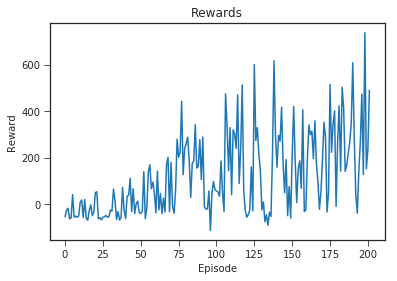

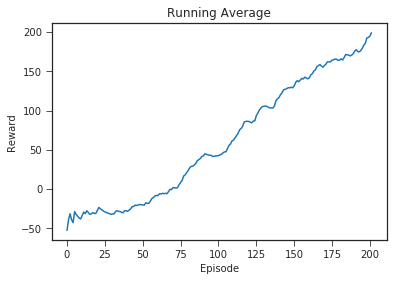

In [14]:
model = Model(env)
gamma = 0.99

N = 202
totalrewards = np.empty(N)
costs = np.empty(N)

for n in range(N):
    eps = 0.5/np.sqrt(n+1+900)
    totalreward, iters = play_one(env, model, eps, gamma)
    totalrewards[n] = totalreward
    print("Episode: ", n, 
          ", iters: ", iters, 
          ", total reward: ", totalreward, 
          ", epsilon: ", eps, 
          ", average reward (of last 100): ", totalrewards[max(0,n-100):(n+1)].mean()
         )
    # We save the model every 10 episodes:
    if n%10 == 0:
        model.model.save('race-car_larger.h5')
        
print("Average reward for the last 100 episodes: ", totalrewards[-100:].mean())
print("Total steps: ", totalrewards.sum())

plt.plot(totalrewards)
plt.title("Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

plot_running_avg(totalrewards)

In [15]:
model.model.save('race-car_test1.h5')

In [16]:
env.close()

[2017-10-20 20:00:18,886] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/diego/Desktop/train_1')


In [15]:
gym.upload('/home/diego/Desktop/monitor-folder', api_key="sk_zuH9mPQ1RVavSFr9VT7JOQ")

[2017-10-17 18:56:50,428] [CarRacing-v0] Uploading 508 episodes of training data


APIConnectionError: Unexpected error communicating with OpenAI Gym (while calling post https://gym-api.openai.com/v1/files). If this problem persists, let us
know at gym@openai.com.

(Network error: ConnectionError: HTTPSConnectionPool(host='gym-api.openai.com', port=443): Max retries exceeded with url: /v1/files (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f1a599d99b0>: Failed to establish a new connection: [Errno -2] Name or service not known',)))